In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import os
import pandas as pd
from scipy.optimize import curve_fit
import random

In [3]:
datapath = './data/'

----

In [2]:
class Solar_plants_data():

    def __init__(self, datapath, geo_metadata_XPV_labeled):
        self.datapath = datapath
        self.plants_metadata = geo_metadata_XPV_labeled
        #self.points = self.read_data(geo_data_XPV_labeled = self.geo_metadata_XPV_labeled)
        
    def read_data(self, geo_data_XPV_labeled = None, path = None, set_points = False):
        '''
        read_data(self, geo_data_XPV_labeled = None, path = None, set_points = False):

        Se leen los metadatos de algún grupo de plantas contenidos en el dataframe o csv indicado en
        geo_data_XPV_labeled o en path según sea el caso. Después se extrae la información de los 
        perfiles de generación, así como de la potencia de las respectivas plantas. 
        Se extraen los valores de generación de la planta al medio día y se devuelve en el array llamado 'points'.
        '''
        if path is not None:
            plants_metadata_df = pd.read_csv(path)
        else:
            plants_metadata_df = geo_data_XPV_labeled

        files = geo_data_XPV_labeled['File_name']
        power_plants_MW = geo_data_XPV_labeled['Power (MW)'].astype('float64')

        self.power_plants_MW = power_plants_MW
        points = []

        for file, MW in zip(files, power_plants_MW):
            plant = pd.read_csv('./data/' + file, header=0, index_col=0, parse_dates=True, squeeze=True)
            midday_data = MW*np.ones((364,2))
            for j in range(364):
                i=2*j+1
                midday_data[j][1] = plant[i*int(288/2):i*int(288/2) + 1]
            points.append(midday_data)
        points = np.array(points) 

        if set_points:
            self.points = points

        return points 
    
    def midday_distributions(self, create_csv = False, plot = False):
        '''
        midday_distributions(create_csv = False, plot = False)
        
        Regresa data frame con potencias de planta y valor diario al medio día durante el año.
        '''
        points_plot = self.points[0]
        for i in self.points[1:]:
            points_plot = np.concatenate((points_plot,i),axis=0)  
        df = pd.DataFrame(columns = ['MW','Power_Midday'], data = points_plot)
        if create_csv:
            df.to_csv(path_or_buf = 'potencia_mediodia.csv', index=False) 
        if plot:
            x = df.MW.values
            y = df.Power_Midday.values
            df.plot.scatter(x = 'MW', y = 'Power_Midday', xlim = [0,x.max()+10], ylim = [0,y.max()+10], s=0.005, c='blue')
        return df
    
    def yearly_max_value(self, create_csv = False, plot = False, fit = False):
        '''
        yearly_max_value(create_csv = False, plot = False, fit = False)
        
        Regresa dataframe con potencias de planta y valor máximo anual al medio día.
        '''
        data = []
        for i in self.points:
            data.append(np.array([np.max(i[:,0]), np.max(i[:,1])]))
        data = np.array(data)

        df = pd.DataFrame(columns = ['MW','Max_Power_Midday'], data = data)
        if create_csv:
            df.to_csv(path_or_buf = 'potencia_mediodia_max.csv', index=False)
        if plot:
            x = df.MW.values
            y = df.Max_Power_Midday.values
            df.plot.scatter(x = 'MW', y = 'Max_Power_Midday', xlim = [0,x.max()+10], ylim = [0,y.max()+10], s=7, c='blue')
        if fit:
            df = pd.DataFrame(columns = ['MW','Power_Midday'], data = data)
        return df
    
    def yearly_mean_value(self, create_csv = False, plot = False, fit = False):
        '''
        yearly_mean_value(create_csv = False, plot = False, fit = False)
        
        Regresa dataframe con potencias de planta y valor máximo anual al medio día.
        '''
        data = []
        for i in self.points:
            data.append(np.array([np.mean(i[:,0]), np.mean(i[:,1])]))
        data = np.array(data)

        df = pd.DataFrame(columns = ['MW','Mean_Power_Midday'], data = data)
        if create_csv:
            df.to_csv(path_or_buf = 'potencia_mediodia_mean.csv', index=False)
        if plot:
            x = df.MW.values
            y = df.Mean_Power_Midday.values
            df.plot.scatter(x = 'MW', y = 'Mean_Power_Midday', xlim = [0,x.max()+10], ylim = [0,y.max()+10], s=7, c='blue')
        if fit:
            df = pd.DataFrame(columns = ['MW','Power_Midday'], data = data)

        return df

    def fit_curve(self, degree = 2, data = 'max', plot = False, scale_factor = None):
        '''
        fit_curve(degree = 2, data = 'max', plot = False, scale_factor = None)
        
        Ajusta una curva de grado especificado tomando como conjunto de ajuste
        los datos que se indiquen. Se forza que el ajuste considere un desfase de 0.

        Inputs:

        points: arreglo de puntos a considerar.
        degree: grado de la curva a ajustar (default: 2). {1,2,3}
        data  : 'max', 'mean', 'all'.
                'max': ajusta la curva a los máximos anuales de la distribución.
                'mean': ajusta la curva al valor promedio anual.
                'all': ajusta la curva a la distribución de datos completa. 
        scale_factor: Si se especifica, se devuelve el valor que devuelve la curva ajustada
                      para ese valor.

        Output:

        y_factor: El valor que devuelvela función ajustada para x=scale_factor.
        params: Contiene los coeficientes del polinomio ajustado. No contiene el offset, pues de 
                considera como cero.

        '''

        def linear(x, a):
            return a*x
        def second(x, a, b):
            return a*x**2 + b*x**1
        def third(x, a, b, c):
            return a*x**3 + b*x**2 + c*x**1

        if data == 'all':
            df = self.midday_distributions()
            ms = 0.15
        elif data == 'max':
            df = self.yearly_max_value(fit = True)
            ms = 5
        elif data == 'mean':
            df = self.yearly_mean_value(fit = True)
            ms = 5
        else:
            return print('Invalid selectionf for "data". Must be in ("all", "max", "mean")')

        #grado
        j = degree
        #datos
        x = df.MW.values
        y = df.Power_Midday.values

        # Curve fitting. returns parameters.
        if degree == 1:
            params = curve_fit(linear, x, y)
            [a] = params[0]
            if scale_factor is not None:
                y_factor = linear(scale_factor,a)
        elif degree == 2:
            params = curve_fit(second, x, y)
            [a,b] = params[0]
            if scale_factor is not None:
                y_factor = second(scale_factor, a, b)
        elif degree == 3:
            params = curve_fit(third, x, y)
            [a,b,c] = params[0]
            if scale_factor is not None:
                y_factor = third(scale_factor, a, b, c)
        else:
            return print('Error: Degree not supported. Must be 1, 2 or 3.')

        if plot:
            x_fit = np.linspace(0, x.max() + 10, 100)
            if degree == 1:
                y_fit = a*x_fit
            elif degree == 2:
                y_fit =  a * x_fit**2 + b*x_fit
            elif degree == 3:
                y_fit = a * x_fit**3 + b * x_fit**2 + c*x_fit
                
            plt.ylim(0, y.max() + 10)
            plt.xlim(0, x.max() + 10)
            plt.plot(x, y, '.', ms=ms)         # Data
            plt.plot(x_fit, y_fit, 'orange')  # Fitted curve

        if scale_factor is not None:
            return y_factor
        else:
            return params[0]
        
    def scale_signal(self, degree, data, MW_out, write_csv = True, plot_hist = False):
        '''
        scale_signal(degree, data, MW_out, write_csv = True, plot_hist = False)
        
        Devuelve un arreglo de valores de generación equivalente a una planta de MW_out
        watts pico instalados. 
        '''

        y_factor = self.fit_curve(degree = degree , data = data, plot = False, scale_factor = MW_out)
        #print(y_factor)

        MW = random.choice(self.power_plants_MW)

        plant = pd.read_csv(self.datapath + '{0}MW.csv'.format(MW), header=0, index_col=0, parse_dates=True, squeeze=True)

        midday_data = MW*np.ones((364,2))
        for j in range(364):
            i=2*j+1
            midday_data[j][1] = plant[i*int(288/2):i*int(288/2) + 1]
        points = midday_data 

        if data == 'mean' or data == 'all':
            N = np.mean(points[:,1])
        elif data == 'max':
            N = np.max(points[:,1])

        df = y_factor*plant/N

        midday_data = MW_out*np.ones((364,2))
        for j in range(364):
            i=2*j+1
            midday_data[j][1] = df[i*int(288/2):i*int(288/2) + 1]
        scalated_points = midday_data 

        if write_csv:
            df.to_csv(path_or_buf = '{}MW.csv'.format(MW_out), index=False)

        if plot_hist:

            pre_plant = pd.DataFrame(columns = ['MW','Power_Midday'], data = points)
            #pre_plant.to_csv(path_or_buf = 'pre_plant.csv', index=False)

            scl_plant = pd.DataFrame(columns = ['MW','Power_Midday'], data = scalated_points)
            #scl_plant.to_csv(path_or_buf = 'scl_plant.csv', index=False)

            plt.figure(figsize=(20,8)) 

            ax1 = plt.subplot(2,4,1)
            ax2 = plt.subplot(2,4,2)

            ax2.hist(pre_plant.Power_Midday, bins=50, label = 'Parent plant', color='orange',edgecolor='purple', alpha=0.5)
            ax2.set_xlabel('{}MW'.format(MW), size=15)

            ax1.hist(scl_plant.Power_Midday, bins=50, label = 'Scalated plant', color='green',edgecolor='purple', alpha=0.5)
            ax1.set_xlabel('{}MW'.format(MW_out), size=15)
            ax1.set_ylabel('Frequency', size=15)

        return df

----

In [5]:
Plant_set = Solar_plants_data(datapath)

In [293]:
Plant_set.read_data(datapath)

array([[[100. ,   4.6],
        [100. ,   2.3],
        [100. ,  68. ],
        ...,
        [100. ,  65.8],
        [100. ,  70.9],
        [100. ,  66.9]],

       [[147. ,  14.6],
        [147. ,   5.7],
        [147. ,  84.6],
        ...,
        [147. , 105.1],
        [147. ,  95. ],
        [147. ,  93. ]],

       [[164. ,  33.8],
        [164. ,  19.5],
        [164. , 100.4],
        ...,
        [164. , 114.6],
        [164. ,  98.7],
        [164. , 117.5]],

       ...,

       [[190. ,  22.5],
        [190. ,  20.2],
        [190. ,  88.5],
        ...,
        [190. , 129.9],
        [190. , 132. ],
        [190. , 113. ]],

       [[170. ,  10. ],
        [170. ,   5.7],
        [170. , 102.3],
        ...,
        [170. , 113.9],
        [170. , 111.8],
        [170. , 113.5]],

       [[ 67. ,   6.9],
        [ 67. ,   2.2],
        [ 67. ,  45.3],
        ...,
        [ 67. ,  42.3],
        [ 67. ,  45.3],
        [ 67. ,  41.4]]])

,MW,Power_Midday
0,100.0,4.6
1,100.0,2.3
2,100.0,68.0
3,100.0,46.5
4,100.0,61.8
...,...,...
2543,67.0,23.2
2544,67.0,10.2
2545,67.0,42.3
2546,67.0,45.3


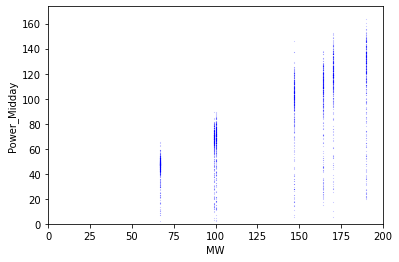

In [6]:
Plant_set.midday_distributions(create_csv=False, plot=True)

,MW,Mean_Power_Midday
0,100.0,62.762637
1,147.0,93.115659
2,164.0,98.030495
3,99.0,60.962912
4,190.0,113.557967
5,170.0,112.958516
6,67.0,44.333791


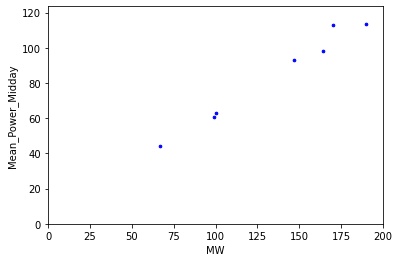

In [7]:
Plant_set.yearly_mean_value(plot = True)

,MW,Max_Power_Midday
0,100.0,89.5
1,147.0,146.3
2,164.0,138.3
3,99.0,89.1
4,190.0,163.8
5,170.0,152.7
6,67.0,65.5


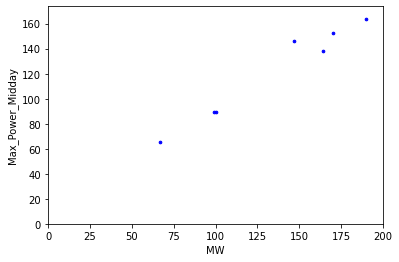

In [8]:
Plant_set.yearly_max_value(plot=True)

array([-1.18084003e-05,  2.55256067e-03,  7.98831159e-01])

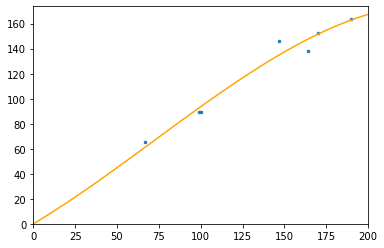

In [13]:
Plant_set.fit_curve(degree = 3 , data = 'max', plot = True)

LocalTime
2006-01-01 00:00:00    0.0
2006-01-01 00:05:00    0.0
2006-01-01 00:10:00    0.0
2006-01-01 00:15:00    0.0
2006-01-01 00:20:00    0.0
                      ... 
2006-12-31 23:35:00    0.0
2006-12-31 23:40:00    0.0
2006-12-31 23:45:00    0.0
2006-12-31 23:50:00    0.0
2006-12-31 23:55:00    0.0
Name: Power(MW), Length: 105120, dtype: float64

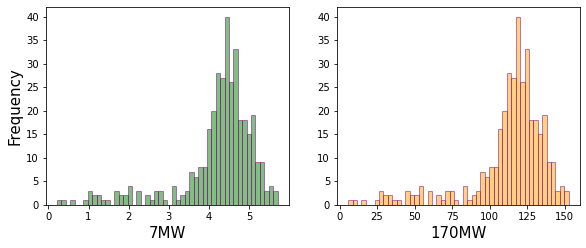

In [14]:
Plant_set.scale_signal(degree=3, data='max', MW_out=7, plot_hist=True)

----